In [1]:
import tensorflow as tf
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
# Bringing in matplotlib for Viz things
from matplotlib import pyplot as plt

In [3]:
# using the tensorflow dataset api to load in the data source  
ds=tfds.load("fashion_mnist",split="train")

In [4]:
ds

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [5]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [6]:
# doing some data transformation
import numpy as np

In [7]:
# setting up data iterator
data_iterator=ds.as_numpy_iterator()

In [8]:
# getting data from the input pipeline
data_iterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

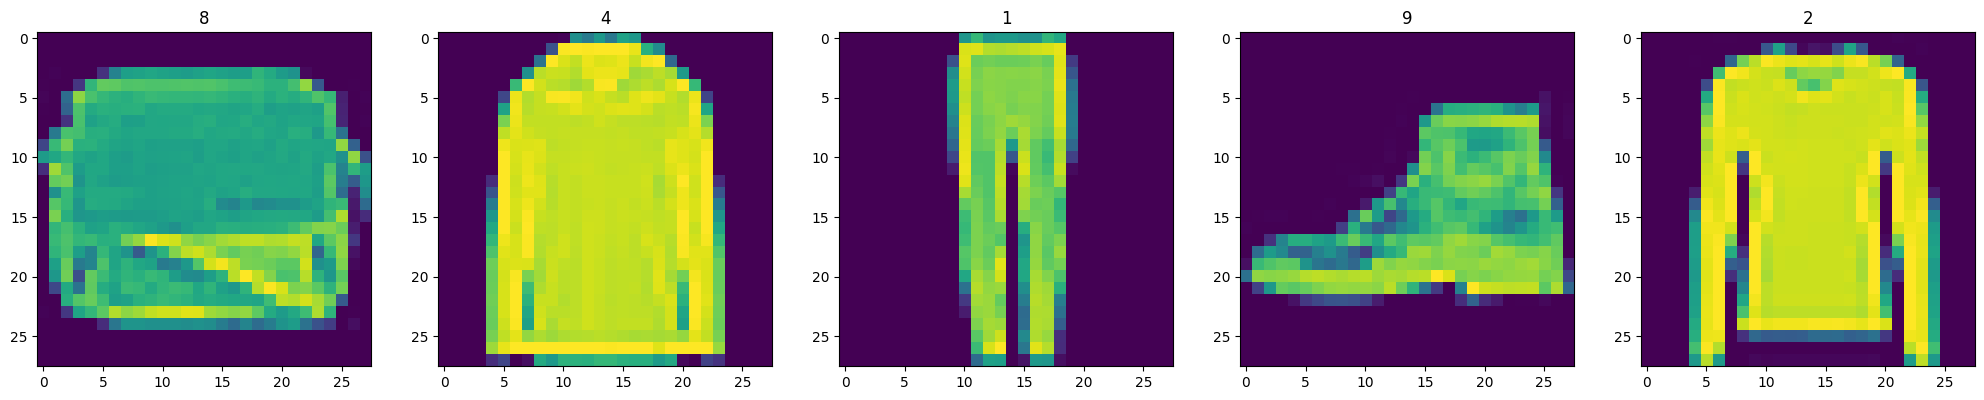

In [10]:
fig, ax=plt.subplots(ncols=5, figsize=(25,25))
for dx in range(5):
    sample=data_iterator.next()
    ax[dx].imshow(np.squeeze(sample['image']))
    ax[dx].title.set_text(sample['label'])